<h1>Lesson 5. Model selection: US Salary Prediction</h1>

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/White_House_lawn_%281%29.tif/lossy-page1-2433px-White_House_lawn_%281%29.tif.jpg style="height:300px;">
  
<p>In this exercise you will use the US Adult Census data relating income to social factors such as Age, Education, race etc...</p>

<p>The goal here is to train a binary classifier on the training dataset to predict the column income_bracket which has two possible values ">50K" and "<=50K" and evaluate the accuracy of the classifier with the test dataset.</p>


In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
import numpy as np

train=pd.read_csv('census-training.csv')
print(train.info())
train.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 10 columns):
Age              48842 non-null int64
EducationNum     48842 non-null int64
MaritalStatus    48842 non-null object
Occupation       48842 non-null object
Relationship     48842 non-null object
Race             48842 non-null object
Gender           48842 non-null object
Hours/Week       48842 non-null int64
Country          48842 non-null object
Income           48842 non-null object
dtypes: int64(3), object(7)
memory usage: 3.7+ MB
None


,Age,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,Hours/Week,Country,Income
0,25,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K.
1,38,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K.
2,28,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K.
3,44,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K.
4,18,10,Never-married,?,Own-child,White,Female,30,United-States,<=50K.
5,34,6,Never-married,Other-service,Not-in-family,White,Male,30,United-States,<=50K.
6,29,9,Never-married,?,Unmarried,Black,Male,40,United-States,<=50K.
7,63,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,32,United-States,>50K.
8,24,10,Never-married,Other-service,Unmarried,White,Female,40,United-States,<=50K.
9,55,4,Married-civ-spouse,Craft-repair,Husband,White,Male,10,United-States,<=50K.


<h3>Q.1. Write a command that will calculate the number of unique values for each feature in the training data.</h3>

In [2]:
train.Income.unique()

# notice that there is extra . at the end of income causing wrong unique value.
train['Income'] = train['Income'].map(lambda x: x.rstrip('.'))
train.Income.unique()

train.nunique()

Age              74
EducationNum     16
MaritalStatus     7
Occupation       15
Relationship      6
Race              5
Gender            2
Hours/Week       96
Country          42
Income            2
dtype: int64

<h3>Q.2. There is a special character '?' inserted in the data in place of null values.  Write a command that will remove it and replace with NaN.</h3>

In [3]:
# Command (s): remove the '?' special character and replace with NaN
train.replace('?', np.nan, inplace=True)
train.isnull().sum() #checking the dataset for NaN values .... NaN values in two columns

Age                 0
EducationNum        0
MaritalStatus       0
Occupation       2809
Relationship        0
Race                0
Gender              0
Hours/Week          0
Country           857
Income              0
dtype: int64

<h3>Q.3. Replace all missing values in Occupation and Country by their mode (most occuring values). </h3>

In [4]:
#Command(s):
modes = train.mode() # finding mode to compute the most occuring item in every column

#replace missing values with their mode
for column in ["Occupation", "Country"]:
    train[column].fillna(train[column].mode()[0], inplace=True)

train.isnull().sum() #checking the data for NaN values .... should all show 0 now
train.head()


,Age,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,Hours/Week,Country,Income
0,25,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K
1,38,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K
2,28,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K
3,44,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K
4,18,10,Never-married,Prof-specialty,Own-child,White,Female,30,United-States,<=50K


<h3>Q.4. Write functions to replace Gender and Income attributes to "0" and "1". </h3>

In [5]:
# converting Gender to "0" and "1" 
def gender_to_numeric(x):
    # return 1 f gender is Male, 0 otherwise
    if x == 'Male':
        return 1
    else:
        return 0

# apply the function to this column
train['Gender'] = train['Gender'].apply(gender_to_numeric)

# converting Inccome to "0" and "1" 
def income_to_numeric(x):
    # return 1 f income is greater than 50k, 0 otherwise
    if x == '>50K':
        return 1
    else:
        return 0
    
# apply the function to this column
train['Income'] = train['Income'].apply(income_to_numeric) 

train.head(10)

,Age,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,Hours/Week,Country,Income
0,25,7,Never-married,Machine-op-inspct,Own-child,Black,1,40,United-States,0
1,38,9,Married-civ-spouse,Farming-fishing,Husband,White,1,50,United-States,0
2,28,12,Married-civ-spouse,Protective-serv,Husband,White,1,40,United-States,1
3,44,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,1,40,United-States,1
4,18,10,Never-married,Prof-specialty,Own-child,White,0,30,United-States,0
5,34,6,Never-married,Other-service,Not-in-family,White,1,30,United-States,0
6,29,9,Never-married,Prof-specialty,Unmarried,Black,1,40,United-States,0
7,63,15,Married-civ-spouse,Prof-specialty,Husband,White,1,32,United-States,1
8,24,10,Never-married,Other-service,Unmarried,White,0,40,United-States,0
9,55,4,Married-civ-spouse,Craft-repair,Husband,White,1,10,United-States,0


<h3>Q.5. Use the label encoder API to encode all object-type in the data. </h3>

In [6]:
# Command(s) 
obj = train.select_dtypes(include=['object']) #all features that are 'object' datatypes
le = preprocessing.LabelEncoder()
for i in range(len(obj.columns)):
    #Encode input data
    print("label encoding column name: ", obj.columns[i])
    train[obj.columns[i]] = le.fit_transform(train[obj.columns[i]])  
    
train.head(10) #Inspect the data, all features should be numeric now

label encoding column name:  MaritalStatus
label encoding column name:  Occupation
label encoding column name:  Relationship
label encoding column name:  Race
label encoding column name:  Country


,Age,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,Hours/Week,Country,Income
0,25,7,4,6,3,2,1,40,38,0
1,38,9,2,4,0,4,1,50,38,0
2,28,12,2,10,0,4,1,40,38,1
3,44,10,2,6,0,2,1,40,38,1
4,18,10,4,9,3,4,0,30,38,0
5,34,6,4,7,1,4,1,30,38,0
6,29,9,4,9,4,2,1,40,38,0
7,63,15,2,9,0,4,1,32,38,1
8,24,10,4,7,4,4,0,40,38,0
9,55,4,2,2,0,4,1,10,38,0


<h3>Q.6. Split the data into 70% training and 30% test </h3>

In [7]:
from sklearn.model_selection import train_test_split

X = train.loc[:, train.columns != 'Income']
y = train.loc[:, train.columns == 'Income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h3>Q.7. Train the logistic regression model on the train dataset and evaluate its performance on the test dataset.</p>

Accuracy: 0.811574421620146
AUC: 0.8249945206349505
Precision: 0.6563834836260085, Recall: 0.4043859649122807, F1 Score: 0.5004523249502442


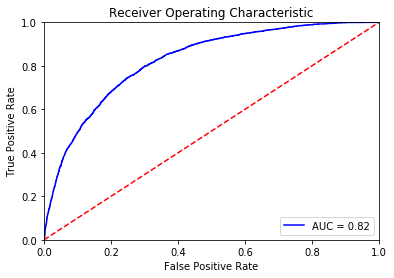

[[10509  2037]
 [  724  1383]]


In [14]:
#Initialize classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Initialize logistic regression classifier
log_rgr = LogisticRegression(fit_intercept = True, C = 1e9) 

# fit X_train and y_train
log_rgr.fit(X_train,y_train)

#predict on the test set
y_pred = log_rgr.predict(X_test)

# Compute the accuracy score
lr_acc = log_rgr.score(X_test, y_test) 
lr_acc

# calculate the fpr and tpr for all thresholds of the classification
probs = log_rgr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.roc_auc_score(y_test, preds)
print("Accuracy: {}".format(lr_acc))
print("AUC: {}".format(roc_auc))

prec = metrics.precision_score(y_test, y_pred)
rec = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)

print("Precision: {}, Recall: {}, F1 Score: {}".format(prec, rec, f1))

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(confusion_matrix(y_test, y_pred).T)

<h3>Q.8. Train the KNN classifier (with k=15) on the train dataset and evaluate its performance on the test dataset. Compare your results with the one above</p>

Accuracy: 0.8147819559134648
AUC: 0.8570707756958795


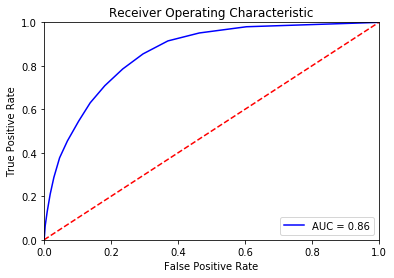

In [9]:
from sklearn.neighbors import KNeighborsClassifier

#Initialize the classifier
clf = KNeighborsClassifier(n_neighbors = 15) #Initialize KNN classifier with k=15

# fit X_train and y_train
clf.fit(X_train,y_train)

# Predicting the Test set results
y_pred = clf.predict(X_test)

# Compute the accuracy score
knn_acc = metrics.accuracy_score(y_test, y_pred) 

# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.roc_auc_score(y_test, preds)
print("Accuracy: {}".format(knn_acc))
print("AUC: {}".format(roc_auc))

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Compare results
# KNN performs better than logistic regression. Both AUC and accuracy values are higher.

<h3>Q.9. Perform recursive feature elimination (5 features) on the dataset using the logistic regression classifier. Any difference in the results? Explain.</h3>

Accuracy: 0.8130075752405651
AUC: 0.7997716887845596
Precision: 0.6665034280117532, Recall: 0.397953216374269, F1 Score: 0.49835225192237276
[False  True  True False  True  True  True False False]
[2 1 1 4 1 1 1 3 5]
Selected features:  ['EducationNum', 'MaritalStatus', 'Relationship', 'Race', 'Gender']
[[10552  2059]
 [  681  1361]]


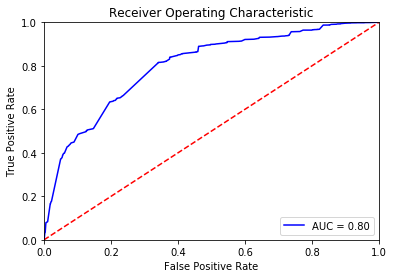

In [13]:
from sklearn.feature_selection import RFE

rfe =  RFE(log_rgr, 5) 

# fit X_train and y_train
rfe.fit(X_train,y_train)

y_predrfe = rfe.predict(X_test)

# Compute the accuracy score
lr_acc = metrics.accuracy_score(y_test, y_predrfe) 

# calculate the fpr and tpr for all thresholds of the classification
probsrfe = rfe.predict_proba(X_test)
predsrfe = probsrfe[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, predsrfe)
roc_auc = metrics.roc_auc_score(y_test, predsrfe)
print("Accuracy: {}".format(lr_acc))
print("AUC: {}".format(roc_auc))
prec = metrics.precision_score(y_test, y_predrfe)
rec = metrics.recall_score(y_test, y_predrfe)
f1 = metrics.f1_score(y_test, y_predrfe)

print("Precision: {}, Recall: {}, F1 Score: {}".format(prec, rec, f1))
print(rfe.support_)
print(rfe.ranking_)

selected_features = []
for num, i in enumerate(X.columns.values):
    if rfe.support_[num] == True:
        selected_features.append(i)
        
print("Selected features: ", selected_features)

print(confusion_matrix(y_test, y_predrfe).T)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# I notice that accuracy, precision of the model increases with RFE. But AUC, Recall and F1 reduces.